In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.dspn import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
from data .Modelnet10toSet import *
from data .pointcloud_utils import *
import matplotlib.pyplot as plt
import random

In [2]:
!pwd
%cd ..
%cd ..
%cd visualisation

/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/Tutorials/DeepSets  MnistSet
/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/Tutorials
/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI
/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/visualisation


In [3]:
train_data = PointCloudData()
test_data = PointCloudData(None, Train=False, folder='test', transform=None)
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
test_loader = DataLoader(test_data, batch_size=32,shuffle=True)

In [4]:
dataset = PointCloudData()
class_names =   [ 'bathtub' , 'bed' , 'chair',  'desk' , 'dresser' , 'monitor' , 'night_stand' , 'sofa' ,  'table' ,  'toilet']
class_names2 = [torch.Tensor(0),torch.Tensor(1),torch.Tensor(2),torch.Tensor(0),torch.Tensor(3),torch.Tensor(4),torch.Tensor(5),torch.Tensor(6),torch.Tensor(7),torch.Tensor(8),torch.Tensor(9)]
sampleSet = []
for i in range(0,len(class_names)):
    for j in range(0,len(dataset)):
        if i == dataset[j]['category']:
            sampleSet.append(dataset[j]['pointcloud'])
            break

In [20]:
class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

In [18]:
set_channels = 3
set_size = 2048
  
hidden_dim = 128
iters = 10
latent_dim = 64
lr = 0.001
inner_lr = 800
n_epochs = 50
set_encoder = MaxEncoderDSPN(set_channels, latent_dim, hidden_dim)
set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
net = Net(input_encoder=None, set_encoder=set_encoder, set_decoder=set_decoder)


In [7]:
net.set_decoder.encoder.salidaConv

tensor([[0.]])

Traning using  cpu
Net(
  (set_encoder): MaxEncoderDSPN(
    (conv): Sequential(
      (0): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
      (1): ReLU(inplace=True)
      (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
  )
  (set_decoder): DSPN(
    (encoder): MaxEncoderDSPN(
      (conv): Sequential(
        (0): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
        (1): ReLU(inplace=True)
        (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      )
    )
  )
)
torch.Size([1, 2048])
La loss:  0.03407846763730049
La loss:  0.03900937736034393
La loss:  0.03511951118707657
La loss:  0.03010515496134758
La loss:  0.036937057971954346
La loss:  0.050313688814640045
La loss:  0.028256483376026154
La loss:  0.0321083664894104
La loss:  0.03702227771282196
La loss:  0.033301714807748795


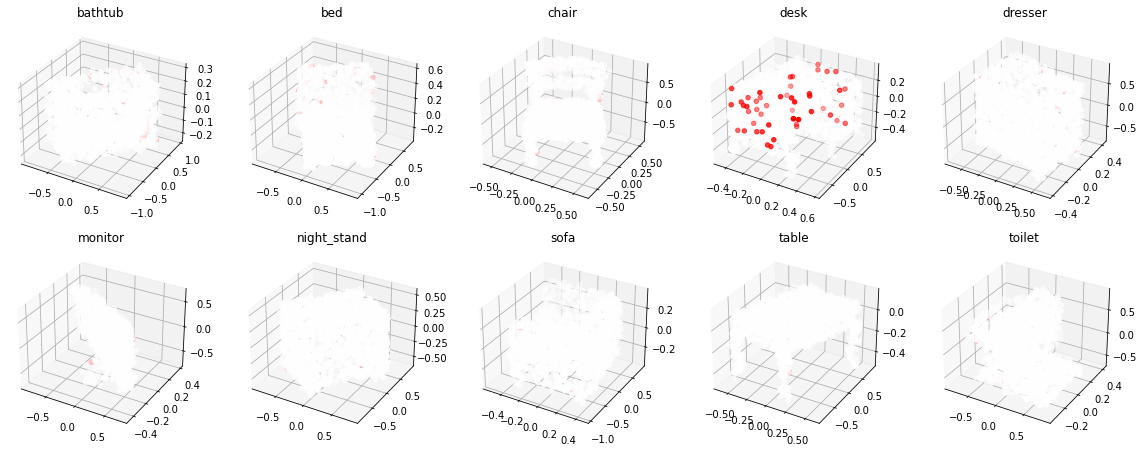

La loss:  0.026492606848478317
La loss:  0.029160231351852417
La loss:  0.025658749043941498
La loss:  0.027608847245573997
La loss:  0.02726888656616211
La loss:  0.03824329003691673
La loss:  0.022182442247867584
La loss:  0.020212676376104355
La loss:  0.026362670585513115
La loss:  0.02159067615866661


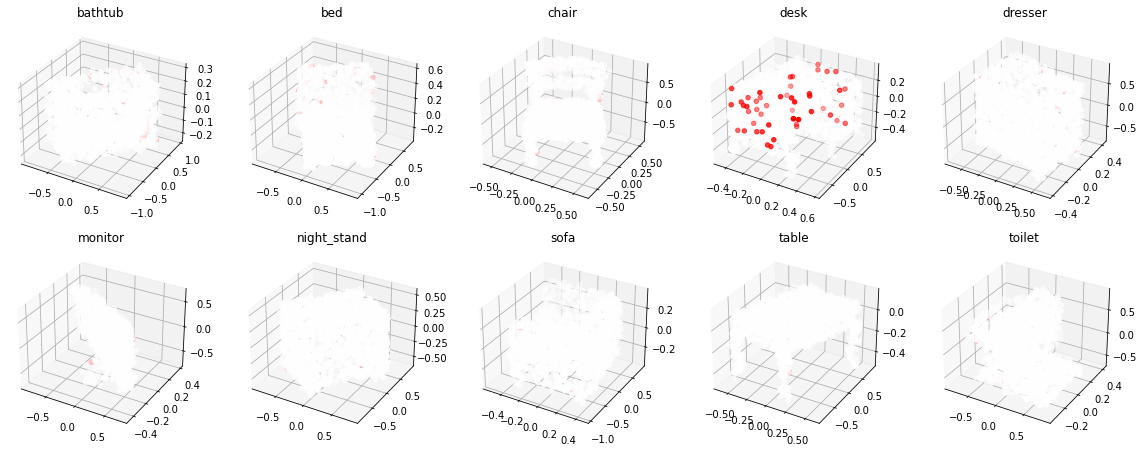

La loss:  0.01803073100745678
La loss:  0.020574279129505157
La loss:  0.015851181000471115
La loss:  0.017262587323784828
La loss:  0.017359532415866852
La loss:  0.026492614299058914
La loss:  0.015165681019425392
La loss:  0.016746817156672478
La loss:  0.01831694133579731
La loss:  0.016804048791527748


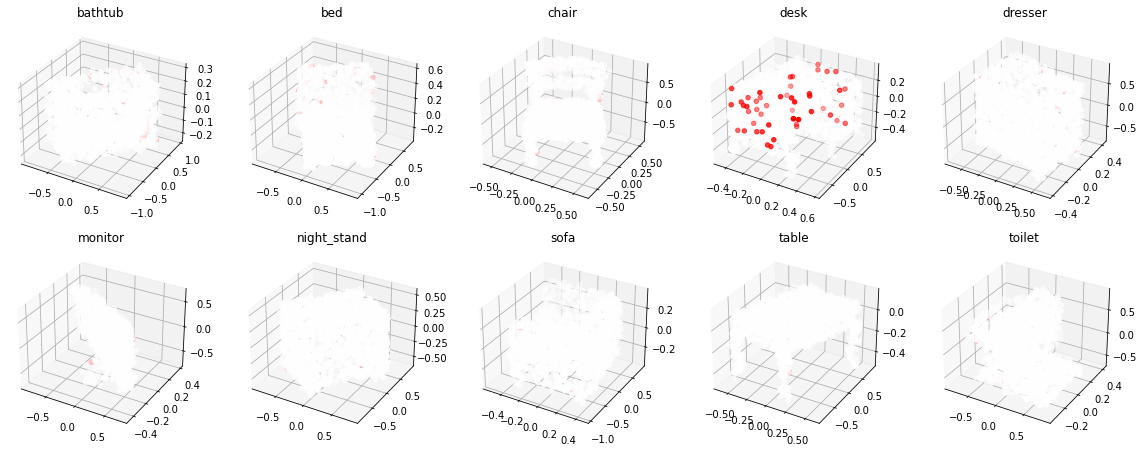

La loss:  0.014857372269034386
La loss:  0.014557819813489914
La loss:  0.011932888999581337
La loss:  0.011222059838473797
La loss:  0.013411137275397778
La loss:  0.019194550812244415
La loss:  0.013482830487191677
La loss:  0.010315196588635445
La loss:  0.012639216147363186
La loss:  0.01063961535692215


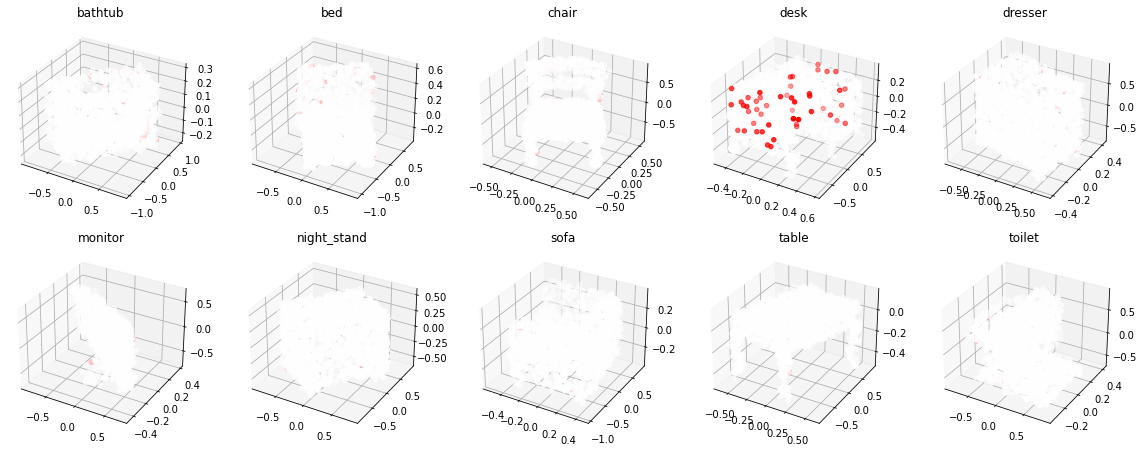

La loss:  0.013920747675001621
La loss:  0.00888125877827406
La loss:  0.0075058829970657825
La loss:  0.007714411709457636
La loss:  0.007915448397397995
La loss:  0.01247198786586523
La loss:  0.008997314609587193
La loss:  0.006559068337082863
La loss:  0.008098069578409195
La loss:  0.0055664945393800735


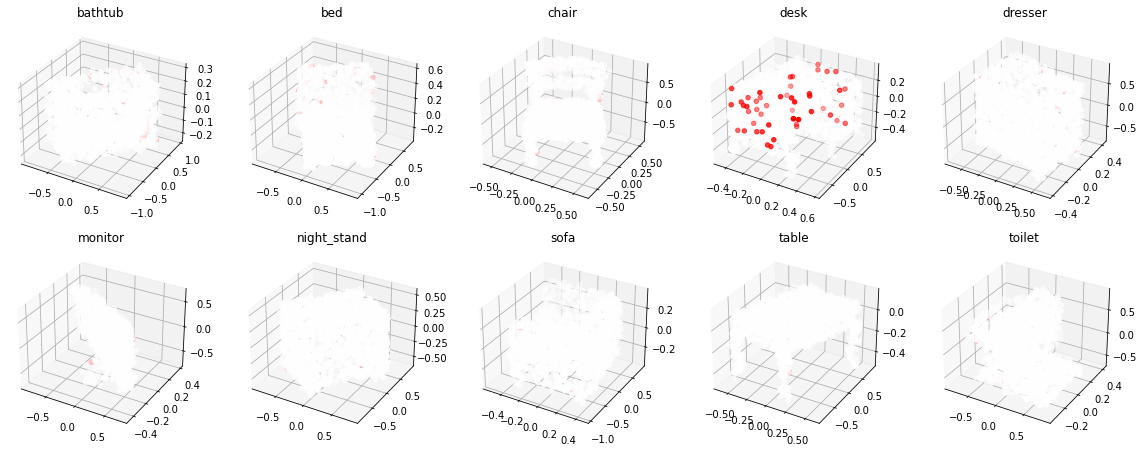

La loss:  0.007441757246851921
La loss:  0.00584500003606081
La loss:  0.004274820908904076
La loss:  0.0046134875155985355
La loss:  0.0063787223771214485
La loss:  0.009706753306090832
La loss:  0.008351068012416363
La loss:  0.005630806554108858
La loss:  0.00596073130145669
La loss:  0.0044957310892641544


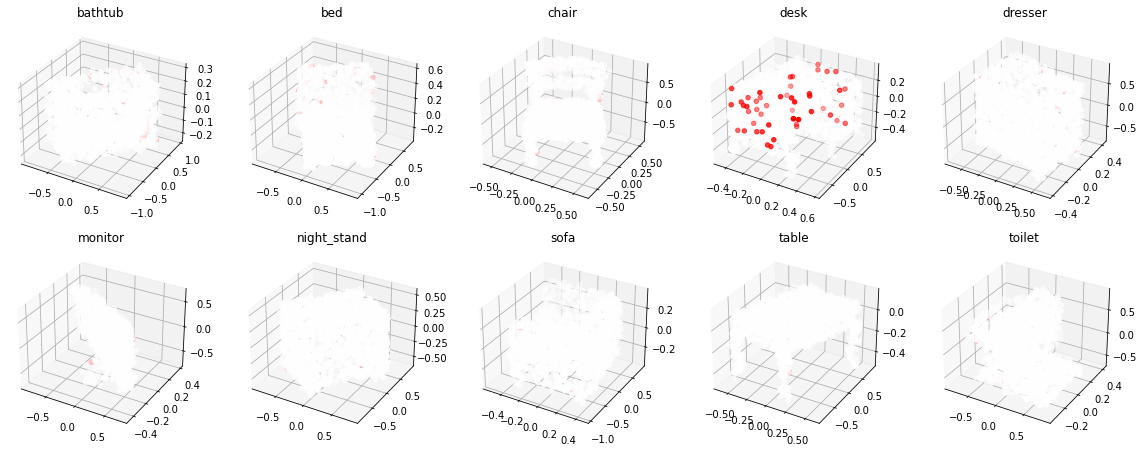

La loss:  0.0066567715257406235
La loss:  0.0049477554857730865
La loss:  0.0038444988895207644
La loss:  0.003961828537285328
La loss:  0.005063100252300501
La loss:  0.007864552550017834
La loss:  0.00802926067262888
La loss:  0.00471649831160903
La loss:  0.004637106787413359
La loss:  0.003595804562792182


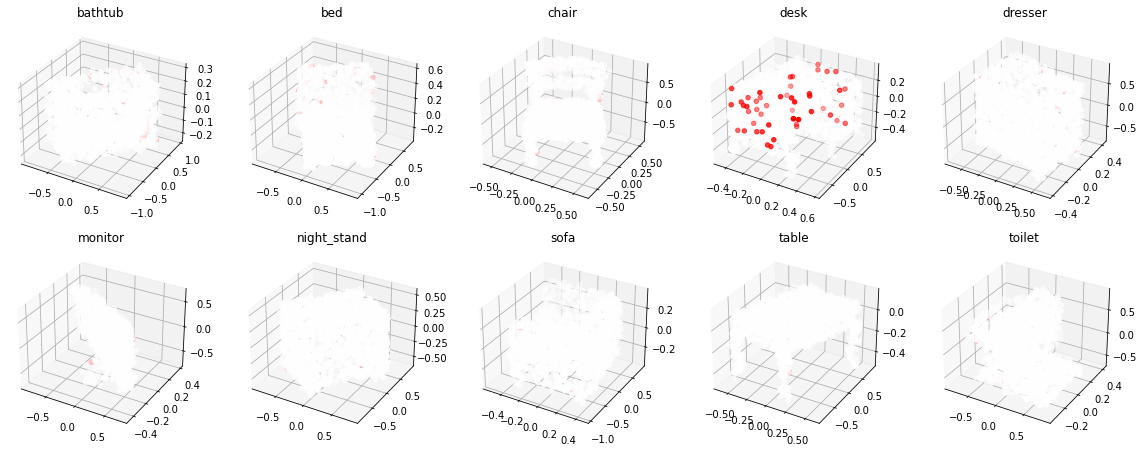

La loss:  0.0058377934619784355
La loss:  0.004154757596552372
La loss:  0.003313594264909625
La loss:  0.003554967697709799
La loss:  0.004099733661860228
La loss:  0.006601708009839058
La loss:  0.007727837190032005
La loss:  0.004154193680733442
La loss:  0.004382206592708826
La loss:  0.0032983680721372366


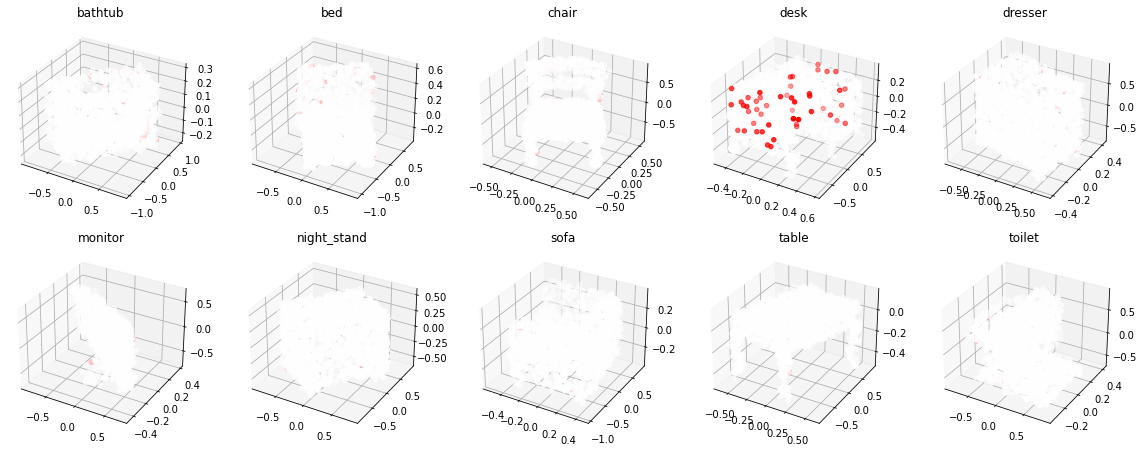

La loss:  0.005203519482165575
La loss:  0.0035167597234249115
La loss:  0.003017703304067254
La loss:  0.0032392083667218685
La loss:  0.003909578546881676
La loss:  0.005936464760452509
La loss:  0.007423059549182653
La loss:  0.0034981458447873592
La loss:  0.0035844824742525816
La loss:  0.002920923288911581


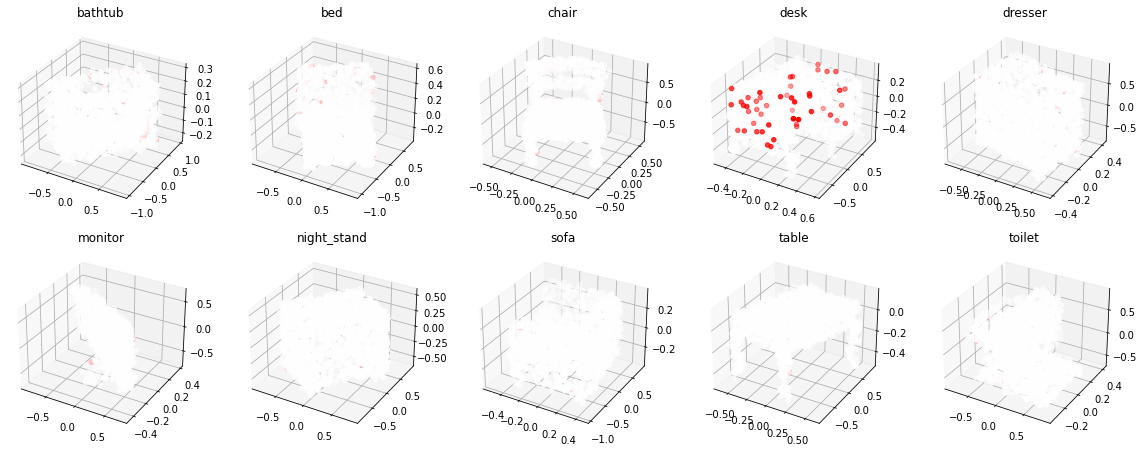

La loss:  0.004687489941716194
La loss:  0.0032634325325489044
La loss:  0.002952024107798934
La loss:  0.002901401137933135
La loss:  0.0033898516558110714
La loss:  0.005467538721859455
La loss:  0.006977373734116554
La loss:  0.0033424487337470055
La loss:  0.0031985929235816
La loss:  0.002799675799906254


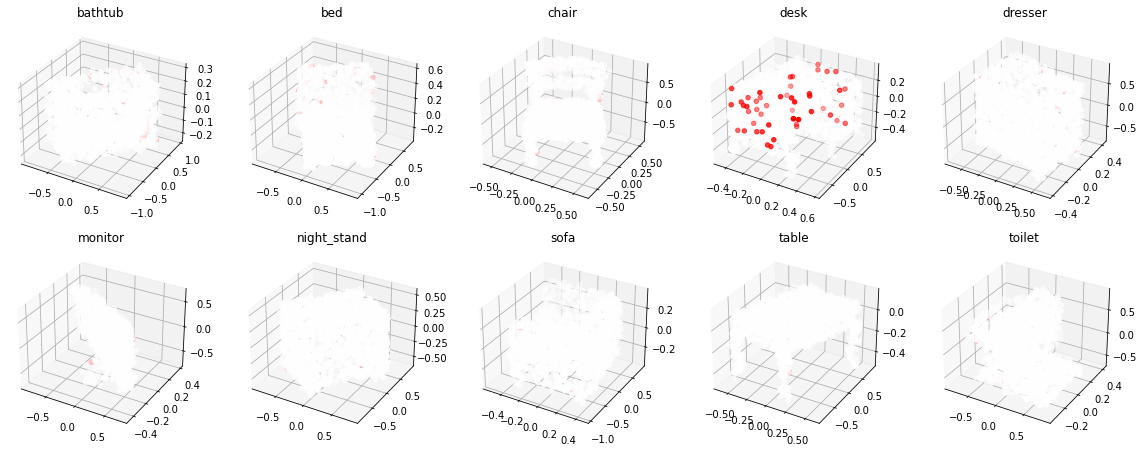

In [21]:
optimizer = torch.optim.Adam(
[p for p in net.parameters() if p.requires_grad], lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Traning using ',device)
net.train()
print(net)
criticos = []
mask = torch.ones(2048).float().unsqueeze(0)
print(mask.shape)
for epoch in range(10):
    for i in range(10):
        label = class_names2[i].unsqueeze(0)
        set = sampleSet[i].unsqueeze(0)
        (progress, masks, evals, gradn), (y_enc, y_label) = net(label, set, mask)
        criticos.append(critical_points_MaxEncoder(net.set_decoder.encoder.salidaConv,sampleSet[i]))
        progress_only = progress
        set = torch.cat([set, mask.unsqueeze(dim=1)], dim=1)
        progress = [torch.cat([p, m.unsqueeze(dim=1)], dim=1)
                        for p, m in zip(progress, masks)]
        set_loss = chamfer_loss(torch.stack(progress), set.unsqueeze(0))
        repr_loss = F.smooth_l1_loss(y_enc, y_label)
        loss = set_loss.mean() +  repr_loss.mean()
        print("La loss: ",loss.item())
        progress = progress_only
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    plotProgressCrit(criticos)

In [14]:
def plotProgressCrit(criticos):
    fig = plt.figure(figsize=(20, 20))
    for i,set in enumerate(sampleSet):
        crit = criticos[i]
        ax = fig.add_subplot(5,5,i+1, projection='3d')
        s = sampleSet[i]
        # plot a 3D surface like in the example mplot3d/surface3d_demo
        surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='w',marker='o',s=20)
        surf2 = ax.scatter(crit[0,:], crit[1,:], crit[2, :],color='r',marker='o',s=20)
        plt.title(class_names[i])
    plt.show()

In [10]:
def critical_points_MaxEncoder(pred, sample):
    critical_points_y = []
    critical_points_x = []
    critical_points_z = []
    #Salida de la capa de convoluciones
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
        critical_points_z.append(points[2,newxmaxargs[k]])
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    z = np.array(critical_points_z)
    s = np.stack((y,x,z))
    
    return s 